## Imports

In [159]:
import numpy as np
import tqdm
from tqdm import tqdm_notebook as tqdm
import math
import tensorflow as tf
import pandas as pd

## Loading data

In [45]:
text = open('train.txt', 'r')
word_dict = {}
X_data, Y_data = [], []
for lines in text:
    line = lines.split()
    for words in line[1:]:
        word_dict.update({line[0] : words})
        X_data.append(line[0])
        Y_data.append(words)
X_data, Y_data = np.array(X_data), np.array(Y_data)
dictionary = word_dict
reverse_dictionary = dict([(v, k) for k, v in dictionary.items()])

In [294]:
print(X_data[:10])

['LEMIEUX' 'MINDING' 'STRIPED' 'KEN' 'CONFERENCE' 'CONFERENCE' 'IMMOLATE'
 'TRANSGRESS' 'RABBLE' 'AIRSHARE']


In [295]:
print(Y_data[:10])

['L_AH_M_Y_UW' 'M_AY_N_D_IH_NG' 'S_T_R_AY_P_T' 'K_EH_N'
 'K_AA_N_F_ER_AH_N_S' 'K_AA_N_F_R_AH_N_S' 'IH_M_AH_L_EY_T'
 'T_R_AE_N_Z_G_R_EH_S' 'R_AE_B_AH_L' 'EH_R_SH_EH_R']


### Баловство

In [298]:
simb2phonDict = {}
gr2coinc = {}
from string import ascii_uppercase
for let in ascii_uppercase:
    gr2coinc.update({let: 0})
phoneme_set = set()
phonemes = reverse_dictionary.keys()
ok = 0
sz3 = 0
for phoneme in phonemes:
    grapheme = list(reverse_dictionary[phoneme])
    phoneme = phoneme.split('_')
    if len(phoneme) > sz3:
        sz3 = len(phoneme)
    for p in phoneme:
        phoneme_set.add(p)
    sz = min(len(grapheme), len(phoneme))
    for i in range(sz):
        simb2phonDict.update({grapheme[i]: phoneme[i]})
        if grapheme[i] == phoneme[i]:
            gr2coinc[grapheme[i]] += 1
for g in gr2coinc.keys():
    print(g, "\t", gr2coinc[g], "\t", simb2phonDict[g])
# for g in simb2phonDict.keys():
#     print(g, "\t", simb2phonDict[g])

U 	 0 	 AH
Y 	 566 	 K
P 	 9570 	 S
L 	 19266 	 AO
G 	 6147 	 S
T 	 17969 	 AH
J 	 0 	 Y
A 	 0 	 AE
D 	 11817 	 D
K 	 5407 	 K
I 	 0 	 L
Z 	 2054 	 AA
H 	 0 	 HH
O 	 0 	 OW
V 	 4893 	 V
Q 	 0 	 R
E 	 0 	 AH
C 	 0 	 IH
M 	 12595 	 M
S 	 16711 	 S
X 	 0 	 K
B 	 9748 	 B
F 	 5572 	 SH
W 	 2871 	 W
R 	 20430 	 R
N 	 21143 	 N


32


## Preparing data

In [4]:
X_vocab = {}
for let in ascii_uppercase:
    X_vocab.update({let: 0})
X_vocab.update({"'" : 0, '-' : 0})
sz2 = 0
for gr in dictionary.keys():
    for l in gr:
        if l in X_vocab.keys():
            X_vocab[l] += 1
        else:
            X_vocab.update({'UNK': 0})
            print(gr)
    if len(gr) > sz2:
        sz2 = len(gr)


In [5]:
print(X_vocab.items())

dict_items([('U', 18607), ('Y', 9888), ('P', 14006), ('L', 35662), ('G', 16816), ('T', 35700), ('J', 1662), ('A', 54333), ('D', 21402), ('K', 11002), ('I', 46686), ("'", 4907), ('Z', 3918), ('H', 17889), ('O', 39591), ('-', 649), ('V', 6467), ('Q', 832), ('E', 69983), ('C', 23850), ('M', 19204), ('S', 46389), ('X', 1424), ('B', 13850), ('F', 8552), ('W', 6829), ('R', 47637), ('N', 44939)])


In [6]:
import operator
X_sorted = [k for k, v in sorted(X_vocab.items(), key=operator.itemgetter(1))][::-1]

In [161]:
X_let_to_ix = {'ZERO' : 0}
v = 1
for k in X_sorted:
    X_let_to_ix.update({k : v})
    v += 1
X_let_to_ix.update({"BGN" : v})
grapheme_sz = v + 1
print(v)

29


In [162]:
X_ix_to_let = dict([(v, k) for k, v in X_let_to_ix.items()])

In [164]:
phoneme2int = {}
v = 1
for phoneme in phoneme_set:
    phoneme2int.update({phoneme : v})
    v += 1
print(v)
phoneme2int.update({"BGN" : v})
phoneme_sz = v + 1
int2phoneme = dict([(v, k) for (k, v) in phoneme2int.items()])
print(phoneme_sz)

40
41


In [297]:
print(Y_data[:10])

['L_AH_M_Y_UW' 'M_AY_N_D_IH_NG' 'S_T_R_AY_P_T' 'K_EH_N'
 'K_AA_N_F_ER_AH_N_S' 'K_AA_N_F_R_AH_N_S' 'IH_M_AH_L_EY_T'
 'T_R_AE_N_Z_G_R_EH_S' 'R_AE_B_AH_L' 'EH_R_SH_EH_R']


In [310]:
sz1 = X_data.shape[0]
sz2 = max(map(len, X_data)) + 1
sz3 = sz2
X_train = np.zeros((sz1, sz2), dtype=np.int)
Y_train = np.zeros((sz1, sz3), dtype=np.int)
i, j = 0, 0
for g in X_data:
    X_train[i][0] = grapheme_sz - 1
    Y_train[i][0] = phoneme_sz - 1
    j = 1
    for l in g:
        X_train[i][j] = X_let_to_ix[l]
        j += 1
    j = 1
    for ph in dictionary[g].split('_'):
        Y_train[i][j] = phoneme2int[ph]
        j += 1
    X_train[i] = X_train[i][::-1]
    i += 1

In [311]:
print(X_train.shape)

(89056, 35)


In [312]:
print(X_train[:5])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 26 13  1  4 12  1  9 29]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 15  6  4 11  6  4 12 29]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 11  1 16  4  3  8  5 29]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  6  1 18 29]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1 10  6  1  3  1 20  6  7 10 29]]


In [313]:
print(Y_train[:5])

[[40 19  2 10 17 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0]
 [40 10 35 39 21 32  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0]
 [40 26  4 15 35 18  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0]
 [40 22 16 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0]
 [40 22 33 39 14 15  2 39 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0]]


In [314]:
print(list(map(lambda x: X_ix_to_let[x], [29, 10, 7, 6, 20, 1, 3, 1, 6, 10, 1])))

['BGN', 'C', 'O', 'N', 'F', 'E', 'R', 'E', 'N', 'C', 'E']


In [315]:
print(list(map(lambda x: int2phoneme[x], [40, 22, 33, 39, 14, 15, 2, 39, 26])))

['BGN', 'K', 'AA', 'N', 'F', 'R', 'AH', 'N', 'S']


## Vectorization

In [316]:
X = np.zeros((sz1, sz2, grapheme_sz))
y = np.zeros((sz1, sz3, phoneme_sz))
print(X.shape)
print(y.shape)

(89056, 35, 30)
(89056, 35, 41)


In [317]:
for i in tqdm(range(sz1)):
    for j in range(sz2):
        X[i, j, X_train[i, j]] = 1
    for k in range(sz3):
        y[i, k, Y_train[i, k]] = 1

Widget Javascript not detected.  It may not be installed or enabled properly.


## Trainig

In [318]:
print(X.shape, y.shape)
max_len = X.shape[1]
n_feats = X.shape[2]
n_outs = y.shape[2]
n_hidden = 32
 
print("Compiling the model ...")
model = Sequential([
    Masking(mask_value=0., input_shape=(max_len, n_feats)),
    LSTM(n_hidden, return_sequences=True),
    LSTM(n_hidden, return_sequences=True),
    LSTM(n_hidden, return_sequences=True),
    TimeDistributed(Dense(n_outs, activation='softmax')),
])
optimizer = RMSprop(lr=0.001, decay=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

(89056, 35, 30) (89056, 35, 41)
Compiling the model ...


In [ ]:
hist = model.fit(X, y, batch_size=5, nb_epoch=5)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/5
  950/89056 [..............................] - ETA: 2:53:03 - loss: 1.0021

In [221]:
# Backward compatibility for TensorFlow's version 0.12: 
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print("TensorFlow's version : 1.0 (or more)")
except: 
    print("TensorFlow's version : 0.12")

TensorFlow's version : 1.0 (or more)


In [285]:

keras.__version__

'2.1.4'

## Neural Network Hyperparametrs

In [ ]:
sample_x, sample_y = generate_x_y_data(isTrain=True, batch_size=3)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

# Internal neural network parameters
seq_length = sample_x.shape[0]  # Time series will have the same past and future (to be predicted) lenght. 
batch_size = 5  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

output_dim = input_dim = sample_x.shape[-1]  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 12  # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 150  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

In [223]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [284]:
tf.__version__

'1.2.0'

In [225]:
PAD = 0
EOS = 1

vocab_size = grapheme_sz
input_embedding_size = 20

encoder_hidden_units = 32
decoder_hidden_units = encoder_hidden_units

In [226]:
import helpers

In [227]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [228]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [229]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

In [230]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [231]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs

In [232]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 32) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 32) dtype=float32>)

In [233]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,

    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [234]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)

In [235]:
decoder_logits

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, ?, 30) dtype=float32>

In [236]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [237]:
sess.run(tf.global_variables_initializer())

In [238]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[ 4  4 19]
 [ 4  4 23]
 [23 23 23]
 [ 2 23 23]]


In [239]:

batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[8, 9, 7, 9, 4, 7, 4, 6]
[3, 3, 6, 4]
[7, 6, 8, 2, 5, 4, 5]
[5, 4, 8, 4, 7, 4, 4]
[9, 2, 6, 5]
[8, 6, 9, 6, 4, 9, 6, 4]
[8, 2, 5, 3, 8, 7]
[8, 4, 9, 7]
[3, 2, 7, 2, 2, 5]
[4, 4, 2, 7, 2]


In [240]:

def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [241]:
loss_track = []
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 3.367331027984619
  sample 1:
    input     > [5 3 7 9 0 0 0 0]
    predicted > [ 4  4 13 24  5  5  5  2  2]
  sample 2:
    input     > [9 5 6 3 9 0 0 0]
    predicted > [ 4  4  4  6 13  5  5 14 14]
  sample 3:
    input     > [8 6 2 4 0 0 0 0]
    predicted > [ 4  5  5  5  6  6  6  2 29]

batch 1000
  minibatch loss: 0.3213512599468231
  sample 1:
    input     > [9 7 6 3 9 4 0 0]
    predicted > [9 7 6 3 9 4 1 0 0]
  sample 2:
    input     > [2 4 6 0 0 0 0 0]
    predicted > [2 4 6 1 0 0 0 0 0]
  sample 3:
    input     > [2 5 9 3 8 3 7 0]
    predicted > [2 5 3 3 3 3 7 1 0]

batch 2000
  minibatch loss: 0.1668933629989624
  sample 1:
    input     > [6 7 2 9 6 0 0 0]
    predicted > [6 7 2 9 6 1 0 0 0]
  sample 2:
    input     > [3 3 8 6 5 0 0 0]
    predicted > [3 3 8 6 5 1 0 0 0]
  sample 3:
    input     > [8 7 6 3 4 0 0 0]
    predicted > [8 7 6 3 4 1 0 0 0]

batch 3000
  minibatch loss: 0.09818622469902039
  sample 1:
    input     > [3 7 5 6 6 7 0 

loss 0.0897 after 300100 examples (batch_size=100)


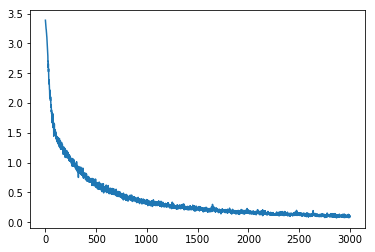

In [242]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))